## Structured Output LLM

In [1]:
import os
from dotenv import load_dotenv
from langchain_anthropic import ChatAnthropic

load_dotenv()

ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [2]:
from pydantic import BaseModel, Field

# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized for web search.")
    justification: str = Field(None, description="Why is this query relevant for the users's request?")

structured_llm = llm.with_structured_output(SearchQuery)

In [3]:
print(SearchQuery())

search_query=None justification=None


In [4]:
output = structured_llm.invoke("where can i but a black boxy lemaire jacket in berlin?")
print(output.search_query)
print(output.justification)

Lemaire black boxy jacket berlin stores retailers
This search query will help find retail locations in Berlin that carry Lemaire clothing, specifically focusing on their black boxy jackets. Lemaire is a luxury fashion brand, and we need to find authorized retailers or boutiques in Berlin that stock their pieces.


## Basic Tool Calling  
TO DO: How to run functions effectively?

In [ ]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

llm_with_tools = llm.bind_tools([multiply])

# This takes the input and creates the arguments to run the function, but it does not run the function
output = llm_with_tools.invoke("What's 2 times 3?")

print(output.tool_calls)

[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01Knkm6Rm4nvW5zo13dnBZ9m', 'type': 'tool_call'}]


In [14]:
print(output)

content=[{'citations': None, 'text': "I'll help you multiply 2 and 3 using the multiply function.", 'type': 'text'}, {'id': 'toolu_01Knkm6Rm4nvW5zo13dnBZ9m', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}] response_metadata={'id': 'msg_01KF49Mmr84snYowaMjeZa4r', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 383, 'output_tokens': 86}} id='run-43522e90-e23a-4a22-9caa-b2c5c7c54e3d-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01Knkm6Rm4nvW5zo13dnBZ9m', 'type': 'tool_call'}] usage_metadata={'input_tokens': 383, 'output_tokens': 86, 'total_tokens': 469}


In [6]:
args_list = [item['args'] for item in output.tool_calls]
print(args_list)

for args in args_list:
    result = multiply(**args)
    print(result)

[{'a': 2, 'b': 3}]
6


## Basic Prompt Chaining

In [7]:
from typing_extensions import TypedDict

#Graph State
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    polished_joke: str


In [8]:
# Nodes
def generate_joke(state: State):

    result = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": result.content} # <- writes back to State!!

def improve_joke(state: State):

    result = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": result.content}

def polish_joke(state: State):

    result = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"polished_joke": result.content}

# Schema for structured output
class Punchline(BaseModel):
    answer: str = Field(None, description="Does this joke have a punchline? Answer Yes or No.")

structured_llm = llm.with_structured_output(Punchline)

# Conditional edge function
def check_punchline(state: State):

    output = structured_llm.invoke(state['joke'])
    if output.answer.lower() == "yes":
        return "Pass"
    else:
        print(f"Punchline check returned: {output.answer}")
        return "Fail"

In [9]:
output = structured_llm.invoke("Why did the chicken cross the road? To get to the other side!")
print(output.answer)

Yes


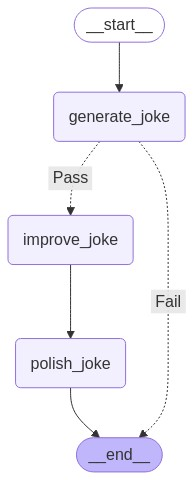

In [10]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
state = graph.invoke({"topic": "germans"})

In [12]:
print(state['joke'])
if "improved_joke" in state:
    print(state['improved_joke'])
    print(state['polished_joke'])

Here's a light joke about Germans:

Why don't Germans tell dad jokes?

Because they're not very punktual! 

(A play on "punctual," since Germans are often stereotyped as being very precise about time, and "pun")
Here's a wordplayed version:

Why don't Germans tell dad jokes?

Because they're not very PUNKTUAL... they always need TIME to think of them, and even then they're not very GERMANE!

(Playing with "punctual," "pun," "German/Germane," and keeping the time reference while adding multiple layers of wordplay)

Alternative punchline:
Because their jokes are the WURST... they need to BERLIN new material!

(Adding "worst/wurst" and "bring in/Berlin" wordplay)
Here's a twist on that joke:

Why don't Germans tell dad jokes?

Because they're not very PUNKTUAL... they always need TIME to think of them, and even then they're not very GERMANE!

But the real reason? Because their CHANCELLOR told one in 1989 and the Berlin Wall came down from all the groaning!

(This adds an unexpected histor

## Parallelization  

Can be useful for multiple perspectives on single task.  
Or if you want to fan out a question into sub-questions

In [15]:
#Graph State
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [16]:
# Nodes
def generate_joke(state: State):

    response = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": response.content}

def generate_story(state: State):

    response = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": response.content}

def generate_poem(state: State):

    response = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": response.content}

def aggregator(state: State):

    combined = f"A story, a joke and a poem about {state['topic']} \n"
    combined += f"joke: \n {state['joke']}\n"
    combined += f"Story: \n {state['story']}\n"
    combined += f"poem: \n {state['poem']}\n"
    return {"combined_output": combined}

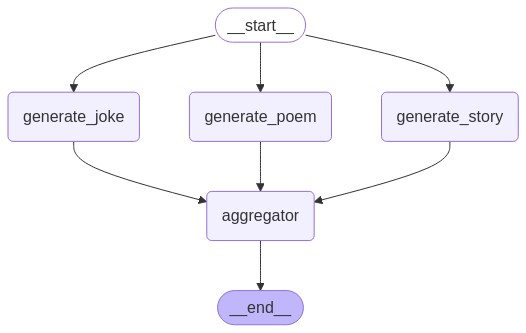

In [18]:
# build workflow
parallel_builder = StateGraph(State)

# set up nodes
parallel_builder.add_node("generate_joke", generate_joke)
parallel_builder.add_node("generate_story", generate_story)
parallel_builder.add_node("generate_poem", generate_poem)
parallel_builder.add_node("aggregator", aggregator)

# connect nodes
parallel_builder.add_edge(START, "generate_joke")
parallel_builder.add_edge(START, "generate_story")
parallel_builder.add_edge(START, "generate_poem")
parallel_builder.add_edge("generate_joke", "aggregator")
parallel_builder.add_edge("generate_story", "aggregator")
parallel_builder.add_edge("generate_poem", "aggregator")
parallel_builder.add_edge("aggregator", END)


parallel_graph = parallel_builder.compile()

display(Image(parallel_graph.get_graph().draw_mermaid_png()))

In [ ]:
state = parallel_graph.invoke({"topic": "germans"})

In [20]:
print(state['combined_output'])

A story, a joke and a poem about germans 
joke: 
 Here's a light-hearted joke about Germans:

How many Germans does it take to change a light bulb?

One. They're efficient and this is no laughing matter.
Story: 
 Here's a story about Germans:

The Baumann Family Legacy

In the small town of Heidelberg, nestled among rolling hills and ancient woodlands, the Baumann family had operated their bakery for over five generations. Every morning at 3 AM, Klaus Baumann would wake up, just as his father and grandfather had done before him, to begin preparing the day's bread and pastries.

The scent of fresh Brötchen and Schwarzbrot would waft through the narrow cobblestone streets, drawing early risers to the warm, cozy shop. Klaus took immense pride in maintaining the exacting standards that had made Baumann's Bäckerei a local institution since 1892.

His daughter, Petra, had grown up watching him work, learning the precise measurements and techniques that made their sourdough unique. Though she

## Routing  

Can be useful for routing a question to different retrivers

In [29]:
from typing_extensions import Literal

# Schema for structured output for routing logic
# this should also be used in the chekc punchline function above
class Route(BaseModel):
    format_choice: Literal["poem", "story", "joke"] = Field(
        None, description="The choice for the routing process"
    )

# Augment the LLM with the schema for structured output
llm_router = llm.with_structured_output(Route)

In [34]:
class State(TypedDict):
    input: str # from the user
    decision: str # from the llm_router
    output: str # from the LLM

In [37]:
from langchain_core.messages import HumanMessage, SystemMessage
# Nodes
def generate_joke(state: State):

    response = llm.invoke(f"Write a joke about {state['input']}")
    return {"output": response.content}

def generate_story(state: State):

    response = llm.invoke(f"Write a story about {state['input']}")
    return {"output": response.content}

def generate_poem(state: State):

    response = llm.invoke(f"Write a poem about {state['input']}")
    return {"output": response.content}

def llm_call_router(state: State):

    decision = llm_router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke or poem based on the user's request."
            ),
            HumanMessage(content=state['input'])
        ]
    )

    return {"decision": decision.format_choice}

# conditional edge to route based on decision
def route_decision(state: State):
    # return the name of the node to go to
    if state["decision"] == "story":
        return "generate_story"
    elif state["decision"] == "joke":
        return "generate_joke"
    elif state["decision"] == "poem":
        return "generate_poem"
    else:
        print("There was a problem with routing")

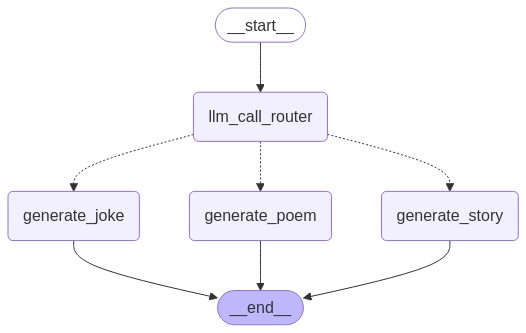

Here's a cat joke:

What do you call a cat that likes to go bowling?
An alley cat!

Or here's another one:

Why don't cats like online shopping?
They prefer a cat-alog!


In [38]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("generate_joke", generate_joke)
router_builder.add_node("generate_story", generate_story)
router_builder.add_node("generate_poem", generate_poem)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "generate_joke": "generate_joke",
        "generate_story": "generate_story",
        "generate_poem": "generate_poem",
    },
)
router_builder.add_edge("generate_joke", END)
router_builder.add_edge("generate_story", END)
router_builder.add_edge("generate_poem", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])